# Interior Point
## March 31st, 2022
### Overview: Using the interior point method to solve linear functions

In [1]:
import numpy as np
from scipy import linalg as la
from scipy.stats import linregress
from matplotlib import pyplot as plt

In [2]:
# Auxiliary Functions ---------------------------------------------------------
def starting_point(A, b, c):
    """Calculate an initial guess to the solution of the linear program
    min c^T x, Ax = b, x>=0.
    Reference: Nocedal and Wright, p. 410.
    """
    # Calculate x, lam, mu of minimal norm satisfying both
    # the primal and dual constraints.
    B = la.inv(A @ A.T)
    x = A.T @ B @ b
    lam = B @ A @ c
    mu = c - (A.T @ lam)

    # Perturb x and s so they are nonnegative.
    dx = max((-3./2)*x.min(), 0)
    dmu = max((-3./2)*mu.min(), 0)
    x += dx*np.ones_like(x)
    mu += dmu*np.ones_like(mu)

    # Perturb x and mu so they are not too small and not too dissimilar.
    dx = .5*(x*mu).sum()/mu.sum()
    dmu = .5*(x*mu).sum()/x.sum()
    x += dx*np.ones_like(x)
    mu += dmu*np.ones_like(mu)

    return x, lam, mu

# Use this linear program generator to test your interior point method.
def randomLP(j,k):
    """Generate a linear program min c^T x s.t. Ax = b, x>=0.
    First generate m feasible constraints, then add
    slack variables to convert it into the above form.
    Parameters:
        j (int >= k): number of desired constraints.
        k (int): dimension of space in which to optimize.
    Returns:
        A ((j, j+k) ndarray): Constraint matrix.
        b ((j,) ndarray): Constraint vector.
        c ((j+k,), ndarray): Objective function with j trailing 0s.
        x ((k,) ndarray): The first 'k' terms of the solution to the LP.
    """
    A = np.random.random((j,k))*20 - 10
    A[A[:,-1]<0] *= -1
    x = np.random.random(k)*10
    b = np.zeros(j)
    b[:k] = A[:k,:] @ x
    b[k:] = A[k:,:] @ x + np.random.random(j-k)*10
    c = np.zeros(j+k)
    c[:k] = A[:k,:].sum(axis=0)/k
    A = np.hstack((A, np.eye(j)))
    return A, b, -c, x

In [47]:
# Problems --------------------------------------------------------------------
def interiorPoint(A, b, c, niter=20, tol=1e-16, verbose=False):
    """Solve the linear program min c^T x, Ax = b, x>=0
    using an Interior Point method.

    Parameters:
        A ((m,n) ndarray): Equality constraint matrix with full row rank.
        b ((m, ) ndarray): Equality constraint vector.
        c ((n, ) ndarray): Linear objective function coefficients.
        niter (int > 0): The maximum number of iterations to execute.
        tol (float > 0): The convergence tolerance.

    Returns:
        x ((n, ) ndarray): The optimal point.
        val (float): The minimum value of the objective function.
    """
    m = A.shape[0]
    n = A.shape[1]
    
    def Functs(x,lam,mu,retF=False):
        #creating F 
        _1 = A.T@lam + mu - c
        _2 = A@x - b
        _3 = np.diag([ui for ui in mu])@x
        F= np.concatenate((_1,_2,_3))
        if retF:
            return F
        
        #make the rows of DF and stack them on top of each other
        row1 = np.hstack((np.zeros((n,n)),A.T,np.identity(n)))
        row2 = np.hstack((A,np.zeros((m,m+n))))
        row3 = np.hstack((np.diag([ui for ui in mu]),np.zeros((n,m)),np.diag([xi for xi in x])))
        DF = np.vstack((row1,row2,row3))
        
        #lu decomp, pivot, and b vector
        LU,piv = la.lu_factor(DF)
        B = -F + np.concatenate((np.zeros(n + m), 0.1*np.dot(x,mu)*np.ones(n)/n ))
        
        #direction from solving
        gradDir = la.lu_solve((LU,piv),B)
        d_x = gradDir[:n]
        d_lam = gradDir[n:m+n]
        d_mu = gradDir[m+n:]
        
        #defining masks and getting alpha max and delta max
        mask_mu = d_mu < 0
        mask_x  = d_x  < 0
        amax = np.min(-mu[mask_mu]/d_mu[mask_mu])
        delmax = np.min(-x[mask_x]/d_x[mask_x])
        
        #getting what alpha and delta are
        a = min(1., 0.95*amax)
        _del = min(1.,0.95*delmax)
        
        #calculate the step sizes
        x_step = _del*d_x
        lam_step = a*d_lam
        mu_step = a*d_mu
        
        nu = np.dot(x,mu)/n
        
        return x_step, lam_step, mu_step, nu
    
    #get starting point
    x0,lam0,mu0 = starting_point(A,b,c)
    
    for k in range(niter):
        #get the step sizes and the nu value
        _x, _lam, _mu, nu = Functs(x0,lam0,mu0)
        
        #step the variables
        x0 += _x
        lam0 += _lam
        mu0 += _mu
        
        #check tol
        
        if nu < tol:
            break
            
    return x0, Functs(x0,lam0,mu0,True)

In [132]:
j, k = 7, 5
A, b, c, x = randomLP(j, k)
point, value = interiorPoint(A, b, c)
np.allclose(x, point[:k])


True

In [153]:
def leastAbsoluteDeviations(filename='simdata.txt'):
    """Generate and show the plot requested in the lab."""
    #load the data and get x and y points
    data = np.loadtxt(filename)
    Y = data.T[0]
    X = data.T[1]
    
    #create variables to use to solve least absolute deviations via problems 1-4
    m = data.shape[0]
    n = data.shape[1] - 1
    c = np.zeros(3*m + 2*(n + 1))
    c[:m] = 1
    y = np.empty(2*m)
    y[::2] = -data[:, 0]
    y[1::2] = data[:, 0]
    x = data[:, 1:]
    A = np.ones((2*m, 3*m + 2*(n + 1)))
    A[::2, :m] = np.eye(m)
    A[1::2, :m] = np.eye(m)
    A[::2, m:m+n] = -x
    A[1::2, m:m+n] = x
    A[::2, m+n:m+2*n] = x
    A[1::2, m+n:m+2*n] = -x
    A[::2, m+2*n] = -1
    A[1::2, m+2*n+1] = -1
    A[:, m+2*n+2:] = -np.eye(2*m, 2*m)
    
    #solution using interior point
    sol = interiorPoint(A, y, c, niter=10)[0]
    
    #separate slope and y intercept
    beta = sol[m:m+n] - sol[m+n:m+2*n]
    b = sol[m+2*n] - sol[m+2*n+1]
    
    #use scipy lineregress
    from scipy.stats import linregress
    slope, intercept = linregress(data[:,1], data[:,0])[:2]
    
    #plotting
    plt.title("Least Abs. Deviation and Line Regression")
    plt.xlabel("x")
    plt.ylabel("y")
    domain = np.linspace(0,10,200)
    #line regress:
    plt.plot(domain, domain*slope + intercept,label='line regress')
    #solution:
    plt.plot(domain, beta*domain+b,label='least abs. dev.')
    plt.scatter(X,Y,color='r',label="data")
    plt.legend()

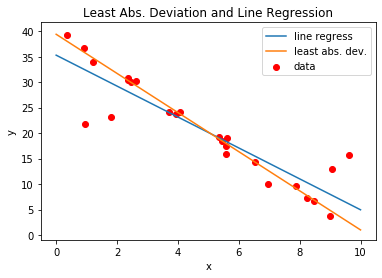

In [154]:
leastAbsoluteDeviations()